In [12]:
#import required libraries files
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pickle
from sklearn.metrics import confusion_matrix #class to calculate accuracy and other metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import Model, layers
from keras.models import Model, load_model
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input, GlobalAveragePooling2D, BatchNormalization, MaxPool2D
from keras.layers import Convolution2D
from keras.applications import ResNet50
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [13]:
dataset_path = "Dataset"
def getID(name): #function to get ID of the MRI view as label
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
#function to read labels from dataset
labels = []
for root, dirs, directory in os.walk(dataset_path):#now loop all files and get labels and then display all birds names
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)
print("Alzhemier Disease View Found in Dataset")  
print(labels)

Alzhemier Disease View Found in Dataset
['Axial', 'Coronal', 'Sagittal']


In [14]:
#now load dataset images
if os.path.exists('model/X.txt.npy'):#if dataset already process then load load it
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if not process the loop all images from dataset
    X = []
    Y = []
    for root, dirs, directory in os.walk(dataset_path):#loop all images from dataset
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images from looping path
                img = cv2.resize(img, (32,32))#resize images
                X.append(img)#add image features to X
                label = getID(name)#get Image ID
                Y.append(label) #add image id as label                
    X = np.asarray(X)
    Y = np.asarray(Y)    
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset MRI Images Loading Completed")
print("Total images found in dataset : "+str(X.shape[0]))

Dataset MRI Images Loading Completed
Total images found in dataset : 5154


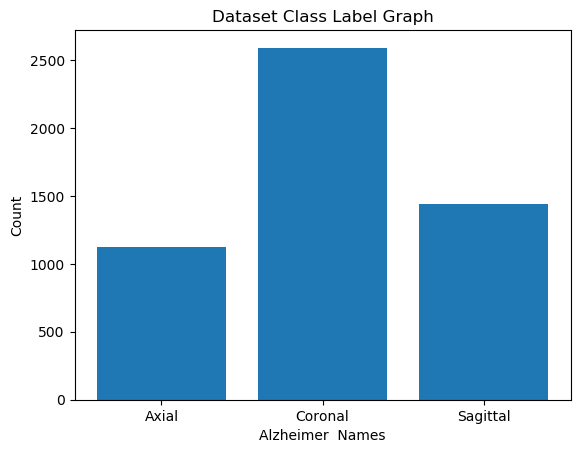

In [15]:
#plot graph of different labels found in dataset
unique, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Alzheimer  Names")
plt.ylabel("Count")
plt.title("Dataset Class Label Graph")
plt.show()

In [16]:
#dataset preprocessing such as shuffling and normalization
X = X.astype('float32')
X = X/255 #normalizing images
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffling images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Dataset Normalization & Shuffling Process completed")

Dataset Normalization & Shuffling Process completed


In [17]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4123
Testing Size (20%): 1031



In [18]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [19]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100  
    print(classification_report(testY, predict, target_names=labels))
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

c:\users\ashis\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



              precision    recall  f1-score   support

       Axial       1.00      0.95      0.97       220
     Coronal       0.95      1.00      0.97       516
    Sagittal       1.00      0.94      0.97       295

    accuracy                           0.97      1031
   macro avg       0.98      0.96      0.97      1031
weighted avg       0.97      0.97      0.97      1031


Pretrained-Resnet50 Accuracy  : 97.18719689621726
Pretrained-Resnet50 Precision   : 98.2262996941896
Pretrained-Resnet50 Recall      : 96.29943502824858
Pretrained-Resnet50 FMeasure    : 97.18525792983851


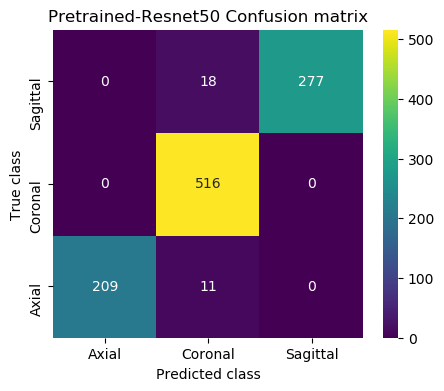

In [11]:
# now train Pretrained Resnet50 model on alzheimer dataset
#create pretrained resnet50 model
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet)#add pretrained model to sequential object
#define new layers for resnet to predict alzheimer and here cnn layer with 32 neurons to filter images features 32 times
resnet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pooling to collect relevant filtered features from CNN layer
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
#defining another layer
resnet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Flatten())
#define output prediction layer
resnet_model.add(Dense(units = 256, activation = 'relu'))
resnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train the model
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model.load_weights("model/resnet_weights.hdf5")
#perform prediction on test data
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
predict[0:960] = test[0:960]
calculateMetrics("Pretrained-Resnet50", predict, test)#call function to calculate accuracy and other metrics